In [1]:
import torch
from torch.linalg import matrix_norm as mn
import numpy as np
import create_data_upd as OD
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

ambient = 400  #784, MNIST
measurements=round(0.25 * ambient)
N_SENSORS=10
#sparse_dim=10
mu = 100 #deafult
batch_size=128

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class ShrinkageActivation(nn.Module):
    def __init__(self):
        super(ShrinkageActivation, self).__init__()

    def forward(self, x, epsilon):
        return torch.sign(x) * torch.max(torch.zeros_like(x), torch.abs(x) - epsilon)


class TruncationActivation(nn.Module):
    def __init__(self):
        super(TruncationActivation, self).__init__()

    def forward(self, x, epsilon):
        return torch.sign(x) * torch.min(torch.abs(x), epsilon * torch.ones_like(x))

class ENCODER:
    def __init__(self,A):
        self.A = A # size: (m ,amb), m=28*28*0.25, amb=28*28

    def measure_x(self, x):
        # Create measurements y
        y = torch.einsum("ma,ba->bm", self.A, x.to(DEVICE)).to(DEVICE)
        return y

    def forward(self, x):
        x = x.view(x.size(0), -1)
        min_x = torch.min(x)
        max_x = torch.max(x)

        y = self.measure_x(x)
        return y,min_x,max_x



""" sending in the network: A, min_x,max_x,y """

class Decoder:
    def __init__(self, A,y,mu, phi,min_x, max_x):
        self.A = A
        self.y = y
        self.min_x = min_x
        self.max_x = max_x

        self.y_noisy = self.noisy_measure(y)
        self.epsilon = torch.norm(self.y - self.y_noisy)
        self.mu = mu
        self.x0 =  torch.einsum("am,bm->ba", self.A.t(), self.y_noisy)

        self.sparse_dim = 400*10
        self.ambient = 400
        self.first_activation = TruncationActivation()
        self.second_activation = ShrinkageActivation()
        self.alpha = 0.7
        self.beta = 0.5
        self.acf_iterations=10

        """learned parameter"""
        self.phi = phi

    def decode(self, y, epsilon, mu, x0, z1, z2, min_x, max_x):
        u1 = z1
        u2 = z2
      #  t1 = ARGS.t10
       # t2 = ARGS.t20
        t1=1
        t2=1 #deafult

        theta1 = 1
        theta2 = 1
        Lexact = torch.tensor([1000.0]).to(DEVICE)

        for _ in range(self.acf_iterations):
            x_hat = (
                    x0
                    + (
                            (1 - theta1) * torch.einsum("as,bs->ba", self.phi.t(), u1)
                            + theta1 * torch.einsum("as,bs->ba", self.phi.t(), z1)
                            - (1 - theta2) * torch.einsum("am,bm->ba", self.A.t(), u2)
                            - theta2 * torch.einsum("am,bm->ba", self.A.t(), u2)
                    )
                    / mu
            )

            w1 = self.affine_transform1(theta1, u1, z1, t1, x_hat)
            w2 = self.affine_transform2(theta2, u2, z2, t2, y, x_hat)

            z1 = self.first_activation(w1, t1 / theta1)
            z2 = self.second_activation(w2, t2 * epsilon / theta2)
            u1 = (1 - theta1) * u1 + theta1 * z1
            u2 = (1 - theta2) * u2 + theta2 * z2

            t1 = self.alpha * t1
            t2 = self.beta * t2
            muL = torch.sqrt(mu / Lexact).to(DEVICE)
            theta_scale = (1 - muL) / (1 + muL).to(DEVICE)
            theta1 = torch.min(torch.tensor([1.0]).to(DEVICE), theta1 * theta_scale)
            theta2 = torch.min(torch.tensor([1.0]).to(DEVICE), theta2 * theta_scale)

        return torch.clamp(x_hat, min=min_x, max=max_x).to(DEVICE)

    def affine_transform1(self, theta1, u1, z1, t1, x):
        affine1 = (
                (1 - theta1) * u1
                + theta1 * z1
                - (t1 / theta1) * torch.einsum("sa,ba->bs", self.phi, x)
        )

        return affine1.detach()

    def affine_transform2(self, theta2, u2, z2, t2, y, x):
        affine2 = (
                (1 - theta2) * u2
                + theta2 * z2
                - (t2 / theta2) * (y - torch.einsum("sa,ba->bs", self.A, x))
        )
        return affine2.detach()
    def noisy_measure(self, y):
        # add Gaussian noise to y
        y_noisy = y + 0.0001 * torch.randn_like(y)
        return y_noisy

    def forward(self, y):
        y_noisy = self.noisy_measure(y)

        x0 = torch.einsum("am,bm->ba", self.A.t(), y_noisy)
        phix0 = torch.einsum("sa,ba->bs", self.phi, x0)
        mu = self.mu

        z1 = torch.zeros_like(phix0)
        z2 = torch.zeros_like(y)

        epsilon = torch.norm(y - y_noisy)

        x_hat = self.decode(y_noisy, epsilon, mu, x0, z1, z2, self.min_x, self.max_x)

        return x_hat


In [4]:
sig1vt_supp=10
zt_noise_sigma=0.01


sig1vt_supp_train=10
zt_noise_sigma_train=0.01
cs_ratio_train=0.25
file_name = f"DECONET(synthetic our data)-10L-4000-red4000-lr0.0001-mu100-initkaiming-datasets_Z_400x10_ksparse=5%_sig1vt_supp={sig1vt_supp_train}_zt_noise_sigma={zt_noise_sigma_train}_cs_ratio={cs_ratio_train}_Sigmoid.pt"
state_dict = torch.load('/home-sipl/prj7482/'+file_name)
A=state_dict['A']
enc = ENCODER(A)

len_test = 1000
rows = ambient
cols = N_SENSORS
data = OD.Data(rows=rows, cols=cols, sig1vt_supp=sig1vt_supp, k_sparse=5,zt_noise_sigma=zt_noise_sigma)
X_dataset_test, C_dataset_test, Z_dataset_test,Zt_dataset_test = data.create_Dataset_save_tag(len_test)
# Z_dataset_test_vecs = Z_dataset_test.transpose(2, 0, 1).reshape(cols, rows * len_test).transpose()
print('Checking Z:')
test=torch.from_numpy(Z_dataset_test).clone().float()

# print('Checking X:')
# test=torch.from_numpy(X_dataset_test).clone().float()

# print('Checking X-AVG:')
# test=torch.from_numpy(X_dataset_test).clone().float()
# test=test-test.mean(axis=2,keepdims=True)

test_loader = DataLoader(
    test,
    num_workers=2,
    batch_size=len_test,
    shuffle=False,
)

criterion = nn.MSELoss()
for i,batch in enumerate(test_loader):
    batch=batch.to(DEVICE)
    y, min_x, max_x = enc.forward(batch)
    phi = state_dict['phi']
    dec = Decoder(A=A, y=y, mu=mu, phi=phi, min_x=min_x, max_x=max_x)
    z_hat = dec.forward(y)
    # print(z_hat)
    # print(z_hat.shape)
    # print(batch)
    mse = criterion(z_hat, batch.view(batch.size(0), -1))
    normal_mse_x=mse/torch.norm(torch.from_numpy(X_dataset_test), p='fro')
    normal_mse_z=mse/torch.norm(batch, p='fro')
    print('mse: ',mse)
    print('normalized by X mse:', normal_mse_x)
    print('normalized by Z mse:', normal_mse_z)



/tmp/ipykernel_76705/52800652.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home-sipl/prj7482/'+file_name)


Checking Z:
mse:  tensor(0.0365, device='cuda:0')
normalized by X mse: tensor(2.8136e-06, device='cuda:0', dtype=torch.float64)
normalized by Z mse: tensor(8.8895e-05, device='cuda:0')


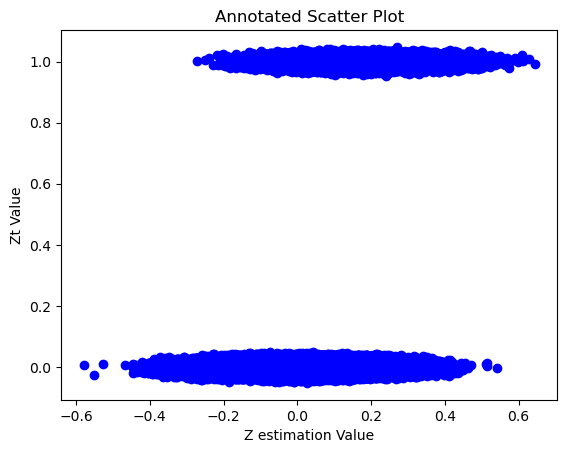

In [5]:
# diff between Z_hat and Z' - did we succeding in reconstruct the non sparse elements? - Sigmoid loss in train
import numpy as np
import matplotlib.pyplot as plt

# Example data points
x = z_hat.flatten().cpu().numpy()
y = Zt_dataset_test.flatten()

fig, ax = plt.subplots()
ax.scatter(x, y, color='blue')

ax.set_title('Annotated Scatter Plot')
ax.set_xlabel('Z estimation Value')
ax.set_ylabel('Zt Value')
plt.show()

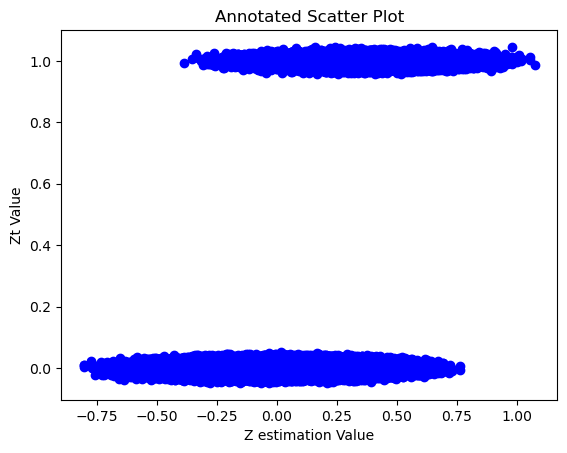

In [3]:
# diff between Z_hat and Z' - did we succeding in reconstruct the non sparse elements? - MAE loss in train
import numpy as np
import matplotlib.pyplot as plt

# Example data points
x = z_hat.flatten().cpu().numpy()
y = Zt_dataset_test.flatten()

fig, ax = plt.subplots()
ax.scatter(x, y, color='blue')

ax.set_title('Annotated Scatter Plot')
ax.set_xlabel('Z estimation Value')
ax.set_ylabel('Zt Value')
plt.show()

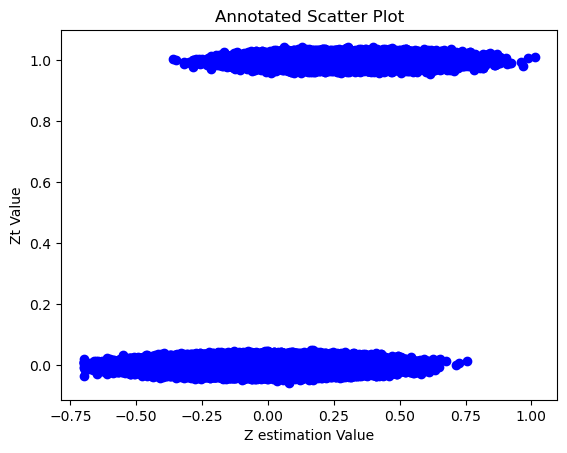

In [9]:
# diff between Z_hat and Z' - did we succeding in reconstruct the non sparse elements? - MSE loss in train
import numpy as np
import matplotlib.pyplot as plt

# Example data points
x = z_hat.flatten().cpu().numpy()
y = Zt_dataset_test.flatten()
#labels = range(1, 400*10*1000)  # Example labels for each point

fig, ax = plt.subplots()
ax.scatter(x, y, color='blue')

# # Annotating each point with its label
# for i, txt in enumerate(labels):
#     ax.annotate(txt, (x[i], y[i]))

ax.set_title('Annotated Scatter Plot')
ax.set_xlabel('Z estimation Value')
ax.set_ylabel('Zt Value')
plt.show()


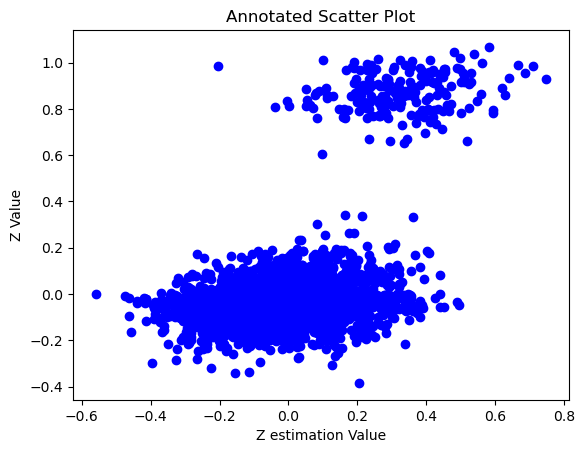

In [8]:
# diff between Z_hat and Z - did we succeding in reconstruct the non sparse elements?
import numpy as np
import matplotlib.pyplot as plt

# Example data points
x = z_hat[0,:].cpu().numpy()
y = Z_dataset_test[0,:,:].flatten()
labels = range(1, 400*10)  # Example labels for each point

fig, ax = plt.subplots()
ax.scatter(x, y, color='blue')

# # Annotating each point with its label
# for i, txt in enumerate(labels):
#     ax.annotate(txt, (x[i], y[i]))

ax.set_title('Annotated Scatter Plot')
ax.set_xlabel('Z estimation Value')
ax.set_ylabel('Z Value')
plt.show()

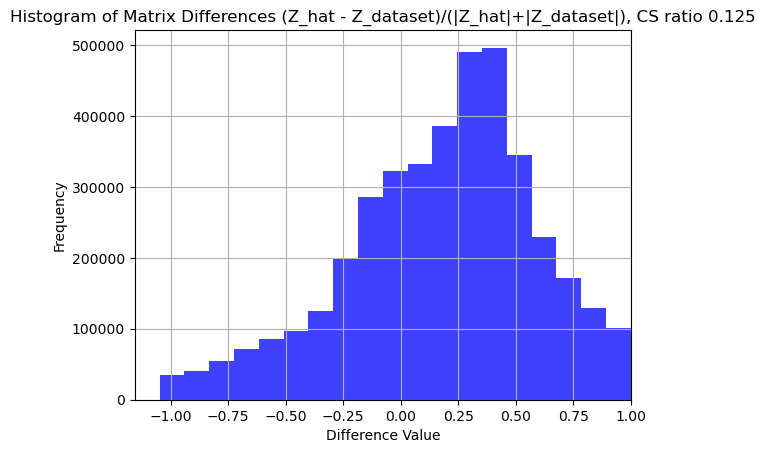

In [42]:
difference =z_hat - batch.view(batch.size(0), -1)/(abs(z_hat) + abs(batch.view(batch.size(0), -1)))
flat_difference = difference.flatten().cpu().numpy()

# Plot the histogram of the differences
plt.hist(flat_difference, bins=20, alpha=0.75, color='blue')
plt.xlim(max(-5, min(flat_difference)), min(5, max(flat_difference)))
#plt.xticks(np.arange(-10, 10, step=0.1))  # More ticks over the range
#plt.xticks(np.arange(min(flat_difference), max(flat_difference), step=(max(flat_difference)-min(flat_difference))/10))  # More ticks over the range
plt.title(f'Histogram of Matrix Differences (Z_hat - Z_dataset)/(|Z_hat|+|Z_dataset|), CS ratio {cs_ratio_train}')
plt.xlabel('Difference Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()